# Purpose:
- Testing boosting algorithms
    - XGBoost takes too long
    - How about LightGBM?
    - Compare running time, including hyperparameter tuning and dropouts
        - Testing feature engineering
- Load Alex's GLM run and compare with them
    - Use random split and specific L2 regularization parameters, not like mean L2 and contiguous split
    - Compare with Alex's results
- Start with 3 examples from each of the 4 cre lines (Slc17a7, VIP, SST, and GAD2)
- Use ML_encoding env
- Mostly copied from 231117_example_design_matrix.ipynb

In [145]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from allensdk.brain_observatory.behavior.behavior_ophys_experiment import BehaviorOphysExperiment
from brain_observatory_qc.data_access import from_lims
import seaborn as sns
import json
from pprint import pprint
from visual_behavior.data_access import loading
import bz2
import pickle
import xarray as xr
from importlib import reload
import glob
from scipy.interpolate import interp1d
from scipy.stats import t

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\visual_behavior_glm')
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_fit_tools as gft
from visual_behavior_glm.glm import GLM

from tqdm.notebook import tqdm

import xgboost as xgb
import lightgbm as lgb

# First, select 3 examples from each of the 4 cre lines
- All from Novel and Novel passive sessions
    - So total 6 x 4 = 24 examples
    - Based on the GLM fit results
- For GAD2-Cre, Novel and the last "extinction" session
- VISp > 200 and < 300 um

In [146]:
alex_result_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\ophys_glm\v_24_events_all_L2_optimize_by_session')
alex_result_df = pd.read_pickle(alex_result_dir / 'results.pkl')
alex_run_param = json.load(open(alex_result_dir / 'run_params.json', 'r'))

In [147]:
alex_result_df.equipment_name.unique()

array(['CAM2P.5', 'CAM2P.4', 'MESO.1', 'CAM2P.3'], dtype=object)

In [149]:
select_df = alex_result_df[alex_result_df.session_type.str.contains('OPHYS_4_') & alex_result_df.cre_line.str.contains('Slc17a7-IRES2-Cre') & \
                           (alex_result_df.targeted_structure == 'VISp') & (alex_result_df.imaging_depth < 300) & (alex_result_df.imaging_depth > 200) & \
                            (alex_result_df.equipment_name == 'MESO.1')]
len(select_df.ophys_experiment_id.unique())

12

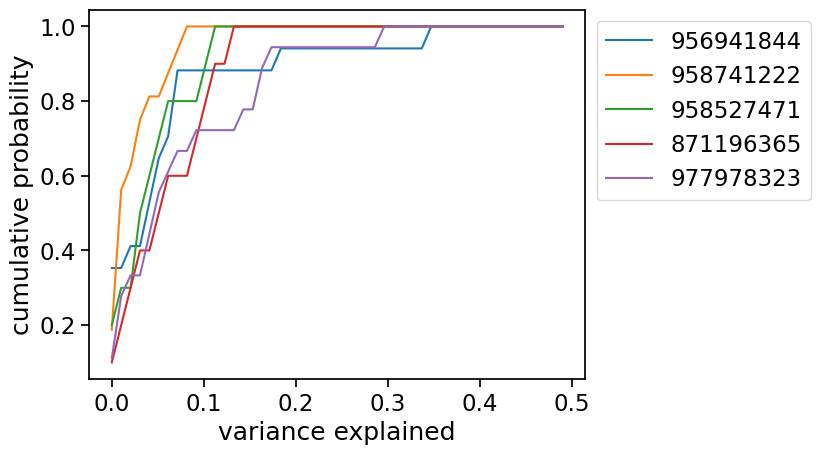

In [151]:
def draw_ve_cum_dist(glm_df, ve_bins=np.linspace(0, 0.5, 50), ax=None):
    if ax is None:
        _, ax = plt.subplots()

    for ophys_experiment_id in glm_df.ophys_experiment_id.unique():
        df = glm_df.query('ophys_experiment_id == @ophys_experiment_id and dropout == "Full"')
        hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
        cumhist_vals = np.cumsum(hist_vals)
        ax.plot(ve_bins[:-1], cumhist_vals, label = ophys_experiment_id)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel('variance explained')
    ax.set_ylabel('cumulative probability')

fig, ax = plt.subplots()
draw_ve_cum_dist(select_df, ax=ax)


In [12]:
ve_bins=np.linspace(0, 0.5, 50)
ve_cutoff=0.1
cutoff_ind = np.where(ve_bins < ve_cutoff)[0][-1]  # the other way of getting the cutoff index (first index larger than the cutoff)
                                                    #gives the second best one, due to an inversion happening exactly at the cutoff
oeids = select_df.ophys_experiment_id.unique()
cumhist_at_cutoff = []
for ophys_experiment_id in oeids:
    df = select_df.query('ophys_experiment_id == @ophys_experiment_id and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    cumhist_at_cutoff.append(cumhist_vals[cutoff_ind])
highest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[0]]
lowest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[-1]]
mid_ve_oied = oeids[np.argsort(cumhist_at_cutoff)[len(oeids)//2]]

In [152]:
# Get the ones with lowest and highest variance explained
# from cumulative probability at variance explained = 0.1

def get_rep_exps_based_on_glm(glm_df, ve_bins=np.linspace(0, 0.5, 50), ve_cutoff=0.1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    cutoff_ind = np.where(ve_bins < ve_cutoff)[0][-1]  # the other way of getting the cutoff index (first index larger than the cutoff)
                                                    #gives the second best one, due to an inversion happening exactly at the cutoff
    oeids = glm_df.ophys_experiment_id.unique()
    cumhist_at_cutoff = []
    for ophys_experiment_id in oeids:
        df = glm_df.query('ophys_experiment_id == @ophys_experiment_id and dropout == "Full"')
        hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
        cumhist_vals = np.cumsum(hist_vals)
        cumhist_at_cutoff.append(cumhist_vals[cutoff_ind])
    highest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[0]]
    lowest_ve_oeid = oeids[np.argsort(cumhist_at_cutoff)[-1]]
    mid_ve_oied = oeids[np.argsort(cumhist_at_cutoff)[len(oeids)//2]]

    df = glm_df.query('ophys_experiment_id == @highest_ve_oeid and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    ax.plot(ve_bins[:-1], cumhist_vals, label = f'{highest_ve_oeid}')
    df = glm_df.query('ophys_experiment_id == @lowest_ve_oeid and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    ax.plot(ve_bins[:-1], cumhist_vals, label = f'{lowest_ve_oeid}')
    df = glm_df.query('ophys_experiment_id == @mid_ve_oied and dropout == "Full"')
    hist_vals = np.histogram(df.variance_explained, bins = ve_bins)[0] / len(df)
    cumhist_vals = np.cumsum(hist_vals)
    ax.plot(ve_bins[:-1], cumhist_vals, label = f'{mid_ve_oied}')
    ax.legend(loc='lower right')
    ax.set_xlabel('variance explained')
    ax.set_ylabel('cumulative probability')
    return (highest_ve_oeid, mid_ve_oied, lowest_ve_oeid)
 

In [47]:
session_type_heading = 'OPHYS_3_'
cre_line_heading = 'Slc17a7'
targeted_structure = 'VISp'
depth_range = (200, 300)
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1])] 
len(select_df.ophys_experiment_id.unique())

9

(989213059, 1084326128, 993369860)


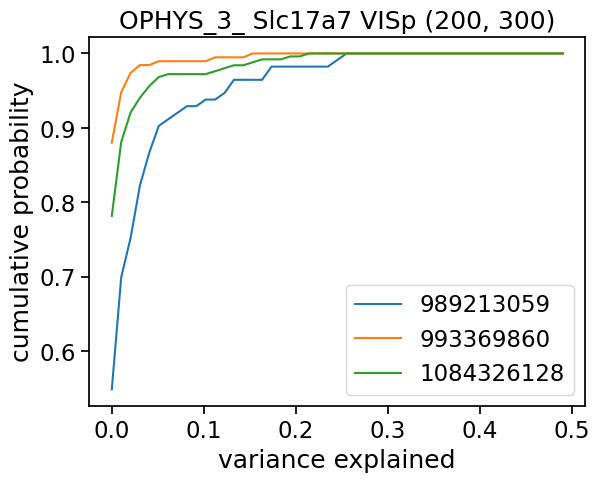

In [49]:
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.07, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range}')
print(oeids)

In [50]:
session_type_heading = 'OPHYS_4_'
cre_line_heading = 'Slc17a7'
targeted_structure = 'VISp'
depth_range = (200, 300)
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1])] 
len(select_df.ophys_experiment_id.unique())

12

(906910612, 1076808542, 1087825602)


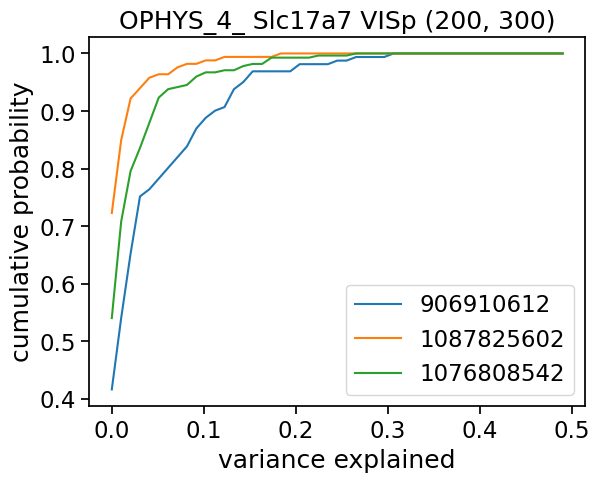

In [51]:
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.07, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range}')
print(oeids)

In [34]:
session_type_heading = 'OPHYS_5_'
cre_line_heading = 'Slc17a7'
targeted_structure = 'VISp'
depth_range = (200, 300)
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1])] 
len(select_df.ophys_experiment_id.unique())

5

Text(0.5, 1.0, 'OPHYS_5_ Slc17a7 VISp (200, 300)')

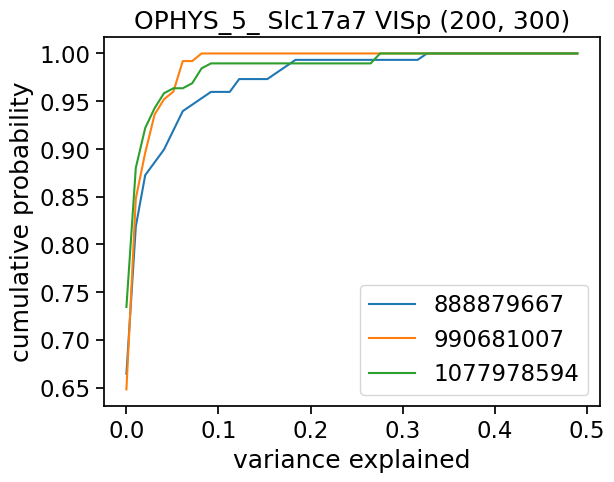

In [36]:
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.07, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range}')

In [39]:
alex_result_df.cre_line.unique()

array(['Slc17a7-IRES2-Cre', 'Vip-IRES-Cre', 'Sst-IRES-Cre'], dtype=object)

(872499144, 944115808, 920288843)


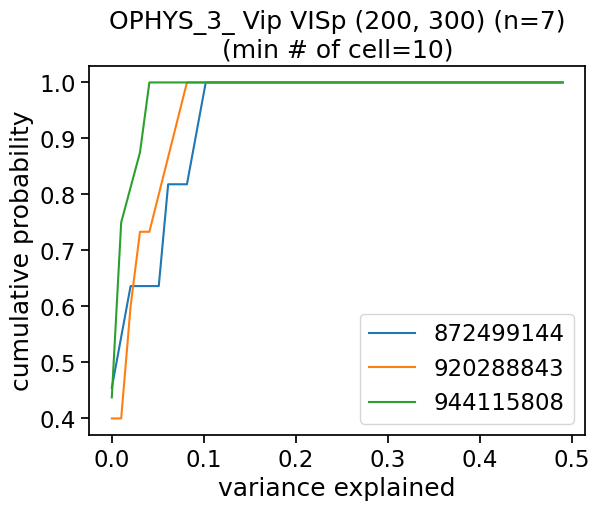

In [159]:
session_type_heading = 'OPHYS_3_'
cre_line_heading = 'Vip'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.1, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
print(oeids)

(882968562, 885146237, 877057336)


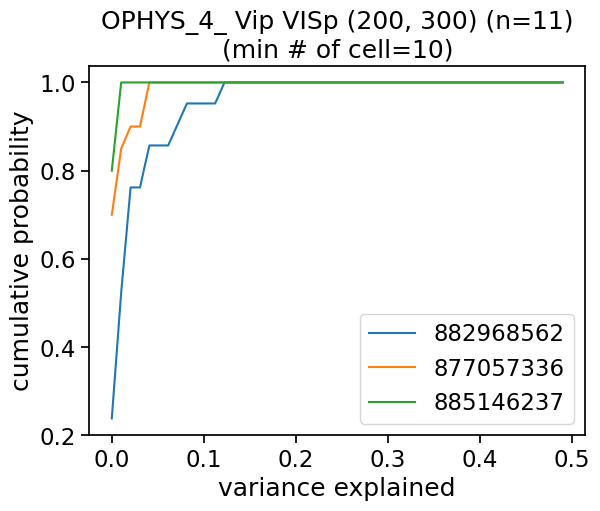

In [161]:
session_type_heading = 'OPHYS_4_'
cre_line_heading = 'Vip'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.1, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
print(oeids)

(922122728, 949723715, 853362765)


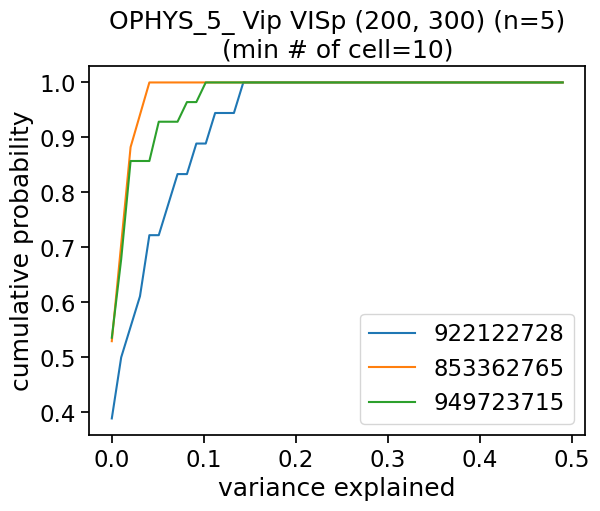

In [162]:
session_type_heading = 'OPHYS_5_'
cre_line_heading = 'Vip'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.1, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
print(oeids)

(871196365, 956941844, 958741222)


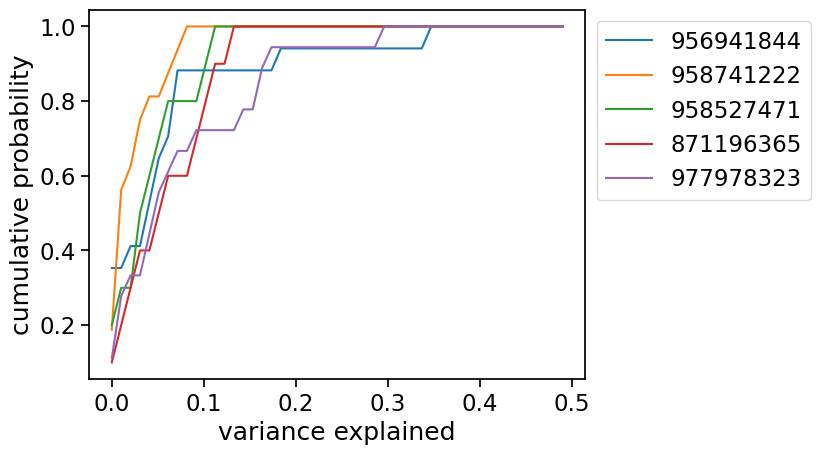

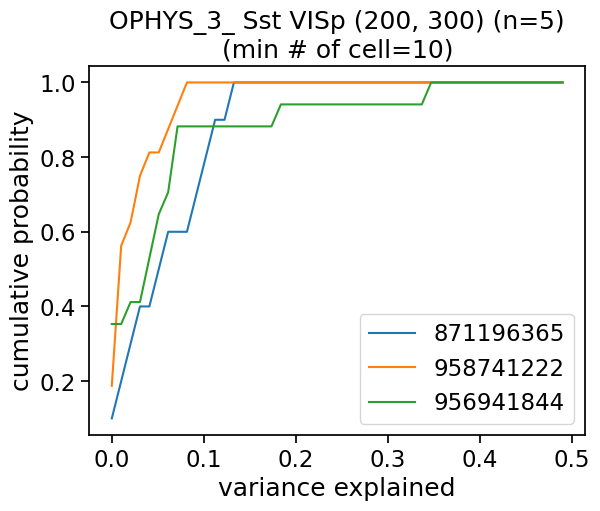

In [153]:
session_type_heading = 'OPHYS_3_'
cre_line_heading = 'Sst'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
draw_ve_cum_dist(select_df, ax=ax)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.05, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
select_df.groupby('ophys_experiment_id').apply(lambda x: len(np.unique(x.cell_roi_id)))

print(oeids)

(978296104, 957759564, 1077790928)


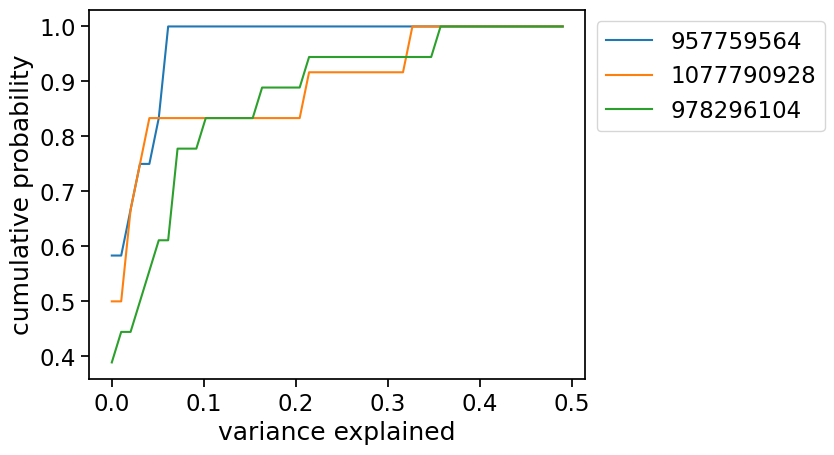

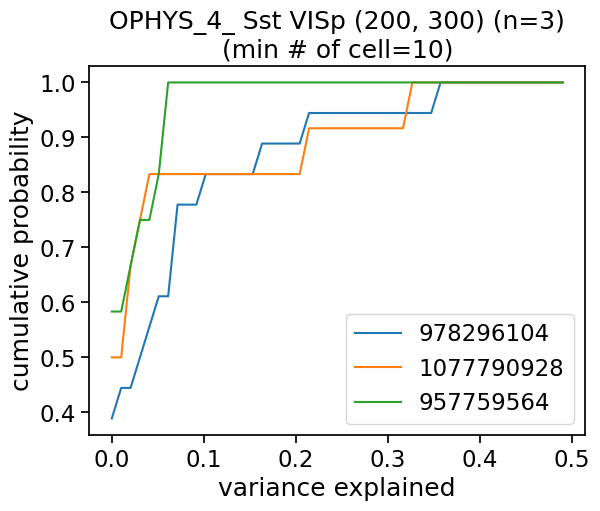

In [156]:
session_type_heading = 'OPHYS_4_'
cre_line_heading = 'Sst'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
draw_ve_cum_dist(select_df, ax=ax)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.05, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
print(oeids)

(986518858, 959388790, 873963889)


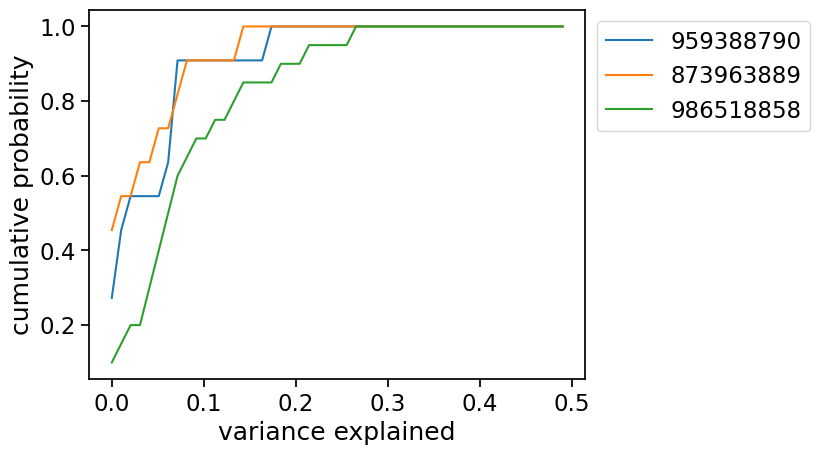

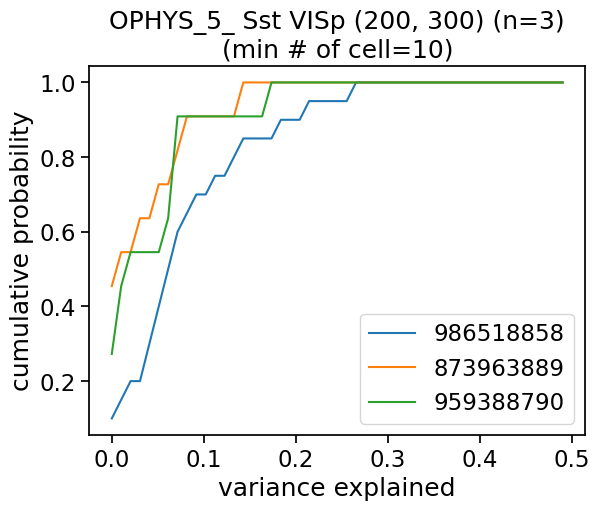

In [157]:
session_type_heading = 'OPHYS_5_'
cre_line_heading = 'Sst'
targeted_structure = 'VISp'
depth_range = (200, 300)
min_num_cell = 10
select_df = alex_result_df[alex_result_df.session_type.str.contains(session_type_heading) & 
                           alex_result_df.cre_line.str.contains(cre_line_heading) &
                           (alex_result_df.targeted_structure == targeted_structure) & 
                           (alex_result_df.imaging_depth > depth_range[0]) &
                           (alex_result_df.imaging_depth < depth_range[1]) &
                           (alex_result_df.equipment_name == 'MESO.1')]
select_df = select_df.groupby('ophys_experiment_id').filter(lambda x: len(np.unique(x.cell_roi_id)) >= min_num_cell)
fig, ax = plt.subplots()
draw_ve_cum_dist(select_df, ax=ax)
fig, ax = plt.subplots()
oeids = get_rep_exps_based_on_glm(select_df, ve_cutoff=0.05, ax=ax)
ax.set_title(f'{session_type_heading} {cre_line_heading} {targeted_structure} {depth_range} (n={len(select_df.ophys_experiment_id.unique())})\n(min # of cell={min_num_cell})')
print(oeids)

# Getting GAD2-Cre data

In [158]:
## Not working due to mongodb connection issue
# glm_version ='version_07_events'
# model_output_type = 'adj_fraction_change_from_full'
# rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
#                                        glm_version=glm_version, cutoff=None)

In [ ]:
# gat.generate_results_summary(glm)

In [62]:
gad2_glm_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\mFish_glm\ophys_glm\v_version_07_events')
gad2_glm_json = json.load(open(gad2_glm_dir / 'run_params.json', 'r'))

In [3]:
fit = gat.load_fit_pkl(gad2_glm_json, 1156776077)

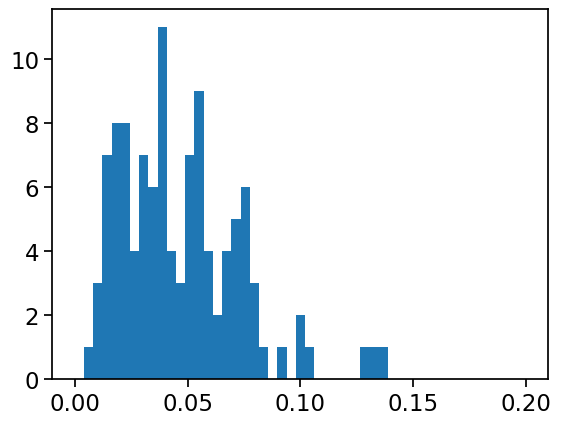

In [8]:
plt.hist(np.nanmean(fit['dropouts']['Full']['cv_var_test'], axis=1), bins=np.linspace(0, 0.2, 50));


In [9]:
filenamepbz2 = gad2_glm_dir / 'experiment_model_files' / f'{1156776077}.pbz2'
with bz2.open(filenamepbz2, 'rb') as f:
    fit = pickle.load(f)

In [10]:
csid = fit['fit_trace_arr'].cell_specimen_id.values
cv_var_test = fit['dropouts']['Full']['cv_var_test']
cv_var_test[np.isinf(cv_var_test)] = np.nan
var_explained = np.nanmean(cv_var_test, axis=1)
assert len(csid) == len(var_explained)


Text(0.5, 1.0, 'Exp: 1156776077')

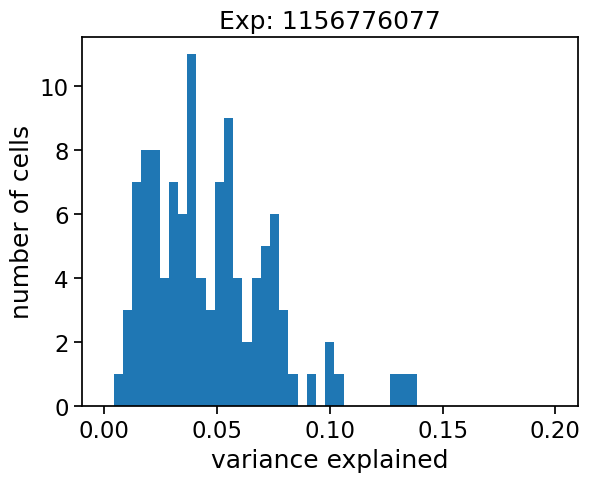

In [11]:
oeid = 1156776077
fig, ax = plt.subplots()
ax.hist(var_explained, bins=np.linspace(0, 0.2, 50));
ax.set_xlabel('variance explained')
ax.set_ylabel('number of cells')
ax.set_title(f'Exp: {oeid}')

### Collect all last Familiar session, first Novel session, and last Extinction session (from lower V1)

In [67]:
gad2_glm_dir

WindowsPath('//allen/programs/braintv/workgroups/nc-ophys/mFish_glm/ophys_glm/v_version_07_events')

In [33]:
# gad2_table = pd.read_csv(gad2_glm_dir / 'experiment_table_v_testing_07_events.csv')
gad2_table = pd.read_csv(gad2_glm_dir / 'experiment_table_v_version_07_events.csv')

In [19]:
gad2_table.keys()

Index(['ophys_experiment_id', 'equipment_name', 'donor_id', 'full_genotype',
       'mouse_id', 'reporter_line', 'driver_line', 'sex', 'age_in_days',
       'foraging_id', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type',
       'experience_level', 'passive', 'image_set', 'date_string', 'cre',
       'n_exposure_session_type', 'session_type_num', 'bisect_layer',
       'depth_order', 'reporter', 'mouse_name', 'short_session_type',
       'n_exposure_short_session_type', 'short_session_type_num',
       'tiny_session_type_num'],
      dtype='object')

In [21]:
gad2_table.session_type.unique()

array(['TRAINING_0_gratings_autorewards_15min', 'TRAINING_1_gratings',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_1_images_A',
       'OPHYS_4_images_B', 'OPHYS_6_images_B'], dtype=object)

In [34]:
targeted_structure = 'VISp'
depth_range = (200, 300)
session_type = 'OPHYS_1_images_A'
temp_gad2_table = gad2_table.query('session_type == @session_type and targeted_structure == @targeted_structure and imaging_depth > @depth_range[0] and imaging_depth < @depth_range[1]')
familiar_table = temp_gad2_table.loc[temp_gad2_table.groupby('mouse_id')['n_exposure_session_type'].idxmax()]
oeids = familiar_table.ophys_experiment_id.values
var_exp_list = []
var_exp_df = pd.DataFrame()
for oeid in oeids:
    filenamepbz2 = gad2_glm_dir / 'experiment_model_files' / f'{oeid}.pbz2'
    if filenamepbz2.exists():
        with bz2.open(filenamepbz2, 'rb') as f:
            fit = pickle.load(f)
        csid = fit['fit_trace_arr'].cell_specimen_id.values
        cv_var_test = fit['dropouts']['Full']['cv_var_test']
        cv_var_test[np.isinf(cv_var_test)] = np.nan
        var_explained = np.nanmean(cv_var_test, axis=1)
        assert len(csid) == len(var_explained)
        var_exp_list.append(var_explained)

        temp_df = pd.DataFrame({'cell_specimen_id': csid, 'var_explained': var_explained})
        temp_df['ophys_experiment_id'] = oeid
        var_exp_df = pd.concat([var_exp_df, temp_df], axis=0)
save_fn = gad2_glm_dir / f'gad2_familiar_var_exp.csv'
var_exp_df.to_csv(save_fn)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_18900\882387928.py:17: RuntimeWarning: Mean of empty slice
  var_explained = np.nanmean(cv_var_test, axis=1)


In [35]:
targeted_structure = 'VISp'
depth_range = (200, 300)
session_type = 'OPHYS_4_images_B'
temp_gad2_table = gad2_table.query('session_type == @session_type and targeted_structure == @targeted_structure and imaging_depth > @depth_range[0] and imaging_depth < @depth_range[1]')
novel_table = temp_gad2_table.loc[temp_gad2_table.groupby('mouse_id')['n_exposure_session_type'].idxmin()]
oeids = novel_table.ophys_experiment_id.values
var_exp_list = []
var_exp_df = pd.DataFrame()
for oeid in oeids:
    filenamepbz2 = gad2_glm_dir / 'experiment_model_files' / f'{oeid}.pbz2'
    if filenamepbz2.exists():
        with bz2.open(filenamepbz2, 'rb') as f:
            fit = pickle.load(f)
        csid = fit['fit_trace_arr'].cell_specimen_id.values
        cv_var_test = fit['dropouts']['Full']['cv_var_test']
        cv_var_test[np.isinf(cv_var_test)] = np.nan
        var_explained = np.nanmean(cv_var_test, axis=1)
        assert len(csid) == len(var_explained)
        var_exp_list.append(var_explained)

        temp_df = pd.DataFrame({'cell_specimen_id': csid, 'var_explained': var_explained})
        temp_df['ophys_experiment_id'] = oeid
        var_exp_df = pd.concat([var_exp_df, temp_df], axis=0)
save_fn = gad2_glm_dir / f'gad2_novel_var_exp.csv'
var_exp_df.to_csv(save_fn)

In [36]:
targeted_structure = 'VISp'
depth_range = (200, 300)
session_type = 'OPHYS_6_images_B'
temp_gad2_table = gad2_table.query('session_type == @session_type and targeted_structure == @targeted_structure and imaging_depth > @depth_range[0] and imaging_depth < @depth_range[1]')
extinction_table = temp_gad2_table.loc[temp_gad2_table.groupby('mouse_id')['n_exposure_session_type'].idxmin()]
oeids = extinction_table.ophys_experiment_id.values
var_exp_list = []
var_exp_df = pd.DataFrame()
for oeid in oeids:
    filenamepbz2 = gad2_glm_dir / 'experiment_model_files' / f'{oeid}.pbz2'
    if filenamepbz2.exists():
        with bz2.open(filenamepbz2, 'rb') as f:
            fit = pickle.load(f)
        csid = fit['fit_trace_arr'].cell_specimen_id.values
        cv_var_test = fit['dropouts']['Full']['cv_var_test']
        cv_var_test[np.isinf(cv_var_test)] = np.nan
        var_explained = np.nanmean(cv_var_test, axis=1)
        assert len(csid) == len(var_explained)
        var_exp_list.append(var_explained)

        temp_df = pd.DataFrame({'cell_specimen_id': csid, 'var_explained': var_explained})
        temp_df['ophys_experiment_id'] = oeid
        var_exp_df = pd.concat([var_exp_df, temp_df], axis=0)
save_fn = gad2_glm_dir / f'gad2_extinction_var_exp.csv'
var_exp_df.to_csv(save_fn)

In [12]:
load_fn = gad2_glm_dir / f'gad2_familiar_var_exp.csv'
var_exp_df_familiar = pd.read_csv(load_fn, index_col=0)
load_fn = gad2_glm_dir / f'gad2_novel_var_exp.csv'
var_exp_df_novel = pd.read_csv(load_fn, index_col=0)
load_fn = gad2_glm_dir / f'gad2_extinction_var_exp.csv'
var_exp_df_extinction = pd.read_csv(load_fn, index_col=0)

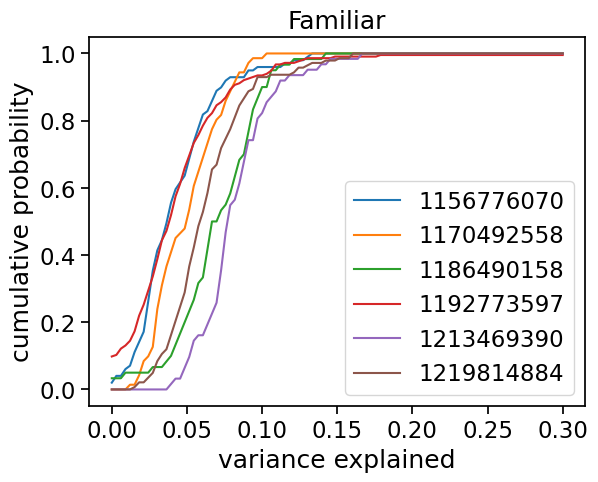

In [36]:
fig, ax = plt.subplots()
bins = [-10, *np.linspace(0, 0.3, 100)]
x = var_exp_df_familiar.groupby('ophys_experiment_id').apply(lambda x: np.cumsum(np.histogram(x.var_explained, bins=bins)[0])/len(x))
inds = var_exp_df_familiar.ophys_experiment_id.unique()
for i in inds:
    ax.plot(bins[1:], x[i], label=i)
ax.set_title('Familiar')
ax.set_xlabel('variance explained')
ax.set_ylabel('cumulative probability')
ax.legend()


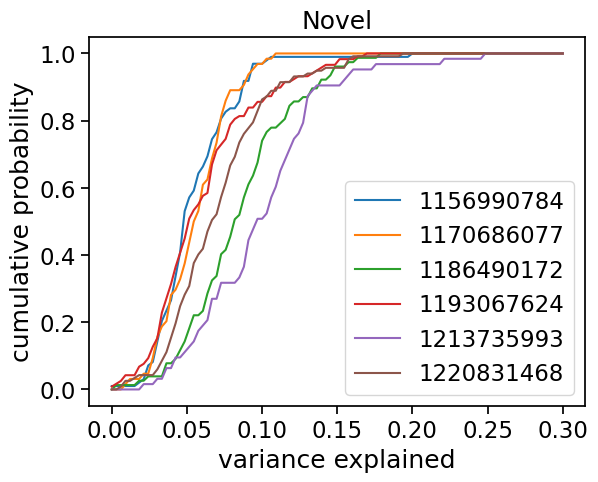

In [37]:
fig, ax = plt.subplots()
bins = [-10, *np.linspace(0, 0.3, 100)]
x = var_exp_df_novel.groupby('ophys_experiment_id').apply(lambda x: np.cumsum(np.histogram(x.var_explained, bins=bins)[0])/len(x))
inds = var_exp_df_novel.ophys_experiment_id.unique()
for i in inds:
    ax.plot(bins[1:], x[i], label=i)
ax.set_title('Novel')
ax.set_xlabel('variance explained')
ax.set_ylabel('cumulative probability')
ax.legend()

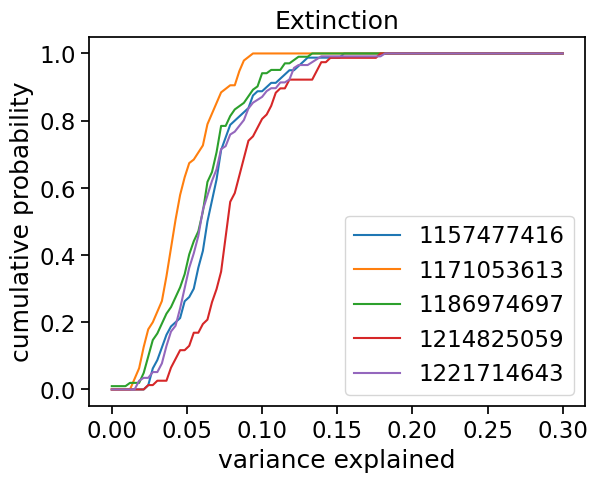

In [38]:
fig, ax = plt.subplots()
bins = [-10, *np.linspace(0, 0.3, 100)]
x = var_exp_df_extinction.groupby('ophys_experiment_id').apply(lambda x: np.cumsum(np.histogram(x.var_explained, bins=bins)[0])/len(x))
inds = var_exp_df_extinction.ophys_experiment_id.unique()
for i in inds:
    ax.plot(bins[1:], x[i], label=i)
ax.set_title('Extinction')
ax.set_xlabel('variance explained')
ax.set_ylabel('cumulative probability')
ax.legend()

## Manual selection experiments
- Slc17a7: 
    - Familiar: 989213059, 1084326128, 993369860
    - Novel: 1076808542, 1087825602, 906910612 
    - Passive: 888879667, 990681007, 1077978594
- VIP: 
    - Familiar: 872499144, 944115808, 920288843
    - Novel: 882968562, 877057336, 885146237
    - Passive: 922122728, 853362765, 949723715
- SST:
    - Familar: 871196365, 956941844, 958741222
    - Novel: 978296104, 957759564, 1077790928
    - Passive: 986518858, 959388790, 873963889
- GAD2:
    - Familar: 1213469390, 1192773597, 1219814884
    - Novel: 1213735993, 1170686077, 1220831468
    - Passive (Extinction): 1214825059, 1171053613, 1157477416

In [163]:
base_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\boosting')
selected_oeids = pd.read_csv(base_dir / 'boosting_test_oeids.csv', index_col=0)
selected_oeids

,cre,session_type
oeid,,
989213059,Slc17a7,familiar
1084326128,Slc17a7,familiar
993369860,Slc17a7,familiar
1076808542,Slc17a7,novel
1087825602,Slc17a7,novel
906910612,Slc17a7,novel
888879667,Slc17a7,passive
990681007,Slc17a7,passive
1077978594,Slc17a7,passive


In [71]:
alex_result_df.query("ophys_experiment_id == 920288843").cell_roi_id.unique()

array([1080764848, 1080764849, 1080764850, 1080764854, 1080764858,
       1080764859, 1080764860, 1080764862, 1080764863, 1080764865,
       1080764868, 1080764869, 1080764870, 1080764872, 1080764875],
      dtype=int64)

# Run GLM, XGBoost, and lightGBM on one example
- VIP, Familar, 920288843 (middle performance, 15 cells)
- Record timing and performance (per cell)

In [14]:
alex_result_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\ophys_glm\v_24_events_all_L2_optimize_by_session')
alex_result_df = pd.read_pickle(alex_result_dir / 'results.pkl')
alex_run_param = json.load(open(alex_result_dir / 'run_params.json', 'r'))

gad2_glm_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\mFish_glm\ophys_glm\v_version_07_events')
gad2_table = pd.read_csv(gad2_glm_dir / 'experiment_table_v_version_07_events.csv')
gad2_glm_json = json.load(open(gad2_glm_dir / 'run_params.json', 'r'))

In [15]:
oeid = 920288843
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\running_speed\running_processing.py:369: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  warnings.warn(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider 

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus


In [16]:
X = design.get_X()

In [7]:
list(X.coords)

['weights', 'timestamps']

In [47]:
coords = list(X.coords)
X.coords[coords[0]].values


array(['intercept_0', 'hits_0', 'hits_1', 'hits_2', 'hits_3', 'hits_4',
       'hits_5', 'hits_6', 'hits_7', 'hits_8', 'hits_9', 'hits_10',
       'hits_11', 'hits_12', 'hits_13', 'hits_14', 'hits_15', 'hits_16',
       'hits_17', 'hits_18', 'hits_19', 'hits_20', 'hits_21', 'hits_22',
       'hits_23', 'hits_24', 'misses_0', 'misses_1', 'misses_2',
       'misses_3', 'misses_4', 'misses_5', 'misses_6', 'misses_7',
       'misses_8', 'misses_9', 'misses_10', 'misses_11', 'misses_12',
       'misses_13', 'misses_14', 'misses_15', 'misses_16', 'misses_17',
       'misses_18', 'misses_19', 'misses_20', 'misses_21', 'misses_22',
       'misses_23', 'misses_24', 'omissions_0', 'omissions_1',
       'omissions_2', 'omissions_3', 'omissions_4', 'omissions_5',
       'omissions_6', 'omissions_7', 'omissions_8', 'omissions_9',
       'omissions_10', 'omissions_11', 'omissions_12', 'omissions_13',
       'omissions_14', 'omissions_15', 'omissions_16', 'omissions_17',
       'omissions_18', 'omiss

In [49]:
X.coords[coords[1]].values.shape

(38408,)

In [48]:
X.values.shape

(38408, 214)

In [54]:
len(session.events.events.values[0])

48318

In [57]:
len(session.ophys_timestamps)

48318

In [60]:
X.coords[coords[1]].values

array([ 308.74394   ,  308.83717063,  308.93040126, ..., 3912.85392314,
       3912.94715377, 3913.04038439])

In [64]:
start_ind = 3200
dur = 20
session.ophys_timestamps[start_ind:start_ind+dur]

array([307.02535, 307.11857, 307.2118 , 307.30503, 307.39825, 307.49148,
       307.58471, 307.67794, 307.77116, 307.86439, 307.95762, 308.05084,
       308.14407, 308.2373 , 308.33053, 308.42375, 308.51698, 308.61021,
       308.70344, 308.79666])

In [59]:
np.where(np.isin(X.coords[coords[1]].values, session.ophys_timestamps))

(array([], dtype=int64),)

In [65]:
# Need interpolation
trace = session.events.events.values[0]
from scipy.interpolate import interp1d
f = interp1d(session.ophys_timestamps, trace, kind='linear')
new_x = X.coords[coords[1]].values
new_trace = f(new_x)

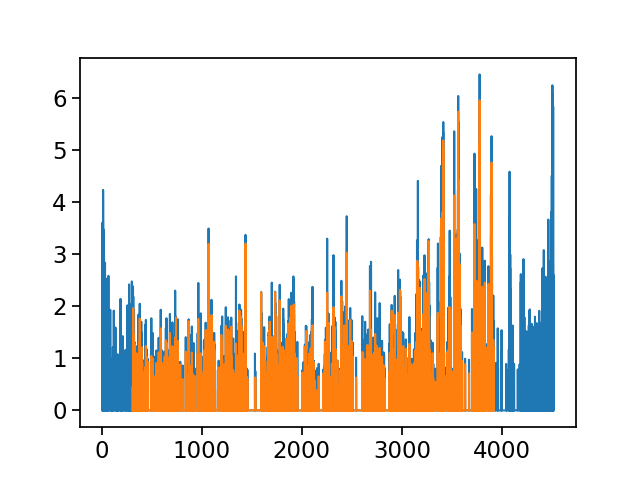

In [69]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(session.ophys_timestamps, trace)
ax.plot(new_x, new_trace)

In [17]:
def get_interpolated_events(session, X):
    num_cells = len(session.events)
    coords = list(X.coords)
    assert coords[1] == 'timestamps'
    X_timestamps = X.coords[coords[1]].values
    interp_events = np.zeros((len(X_timestamps), num_cells))
    for ci in range(num_cells):
        trace = session.events.events.values[ci]
        f = interp1d(session.ophys_timestamps, trace, kind='linear')
        interp_events[:, ci] = f(X_timestamps)
    interp_events = xr.DataArray(interp_events, coords=[X.coords[coords[1]].values, session.events.index.values], dims=[coords[1], 'cell_specimen_id'])
    return interp_events

In [93]:
interp_events = get_interpolated_events(session, X)
interp_events.shape

(38408, 15)

In [94]:
interp_events

<xarray.DataArray (timestamps: 38408, cell_specimen_id: 15)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12456154, ..., 0.        , 0.        ,
        0.57680063],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15736081,
        0.        ],
       [0.        , 0.        , 0.14279114, ..., 0.        , 0.20165283,
        0.        ]])
Coordinates:
  * timestamps        (timestamps) float64 308.7 308.8 ... 3.913e+03 3.913e+03
  * cell_specimen_id  (cell_specimen_id) int64 1086571383 ... 1086576588

## GLM
- A little tweak to improve previous GLM
- with just events, not filtered
1. Random splitting (with stratification on response, image, and engagement - later)
2. Use cell-specific L2 regularization parameter
3. New L2 regularization parameter for every feature dropouts
4. No adjusted variance explained (since it ignores false positives)
5. "prediction" based on the real prediction using the split, not from the re-calculation using the whole data (will lead to overfitting)

In [72]:
def get_split_inds(X, num_folds=5):
    time_inds = np.arange(len(X.timestamps.values))
    np.random.shuffle(time_inds)
    ridge_splits_inds = np.array_split(time_inds, num_folds)
    np.random.shuffle(time_inds)
    fit_splits_inds = np.array_split(time_inds, num_folds)
    assert len(np.unique(np.concatenate(ridge_splits_inds))) == len(np.unique(np.concatenate(fit_splits_inds))) == len(time_inds)
    assert len(ridge_splits_inds) == len(fit_splits_inds) == num_folds
    assert np.abs(np.diff([len(x) for x in ridge_splits_inds])).max() <= 1
    assert np.abs(np.diff([len(x) for x in fit_splits_inds])).max() <= 1

    return ridge_splits_inds, fit_splits_inds


In [39]:
def fit_regularized(interp_events, X, lam):
    '''
    Analytical OLS solution with added L2 regularization penalty. 

    traces: xarray with shape (n_timestamps * n_cells)
    X: xarray with shape (n_timestamps * n_kernel_params)
    lam (float): Strength of L2 regularization (hyperparameter to tune)

    Returns: XArray
    '''
    # Compute the weights
    W = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[-1])),
               np.dot(X.T, interp_events.values))

    # Make xarray
    cellids = interp_events.coords['cell_specimen_id'].values[:]
    W_xarray= xr.DataArray(
            W, 
            dims =('weights','cell_specimen_id'), 
            coords = {  'weights':X.weights.values, 
                        'cell_specimen_id':cellids}
            )
    return W_xarray


def fit_regularized_single(trace, X, lam):
    '''
    Analytical OLS solution with added L2 regularization penalty. 

    traces: 1d array (n_timestamps)
    X: xarray with shape (n_timestamps * n_kernel_params)
    lam (float): Strength of L2 regularization (hyperparameter to tune)

    Returns: XArray
    '''
    # Compute the weights
    # try:
    W = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[-1])),
            np.dot(X.T, trace))
    # except:
    #     try:
    #         lam += 0.001
    #         W = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[-1])),
    #                 np.dot(X.T, trace))
    #     except:
    #         W = xr.DataArray(np.zeros(X.shape[-1]),
    #                         dims='weights',
    #                         coords={'weights': X.weights.values})

    return W


def find_optimal_lam(interp_events, X, ridge_split_inds, lam_range=np.geomspace(1e-3, 1e5, 200)):
    num_folds = len(ridge_split_inds)
    num_cells = interp_events.shape[1]
    mse_all = np.zeros((num_cells, len(lam_range), num_folds))
    for fi in range(num_folds):
        train_inds = np.concatenate([ridge_split_inds[i] for i in range(num_folds) if i != fi])
        test_inds = ridge_split_inds[fi]
        X_train = X.isel(timestamps=train_inds)
        X_test = X.isel(timestamps=test_inds)
        interp_events_train = interp_events.isel(timestamps=train_inds)
        interp_events_test = interp_events.isel(timestamps=test_inds)
        for li, lam in enumerate(lam_range):
            W = fit_regularized(interp_events_train, X_train, lam)
            pred = np.dot(X_test.values, W.values)
            mse = np.mean((pred - interp_events_test.values)**2, axis=0)
            mse_all[:, li, fi] = mse
    mean_mse = np.mean(mse_all, axis=-1)
    optimal_lam = xr.DataArray(lam_range[np.argmin(mean_mse, axis=1)],
                                 dims='cell_specimen_id',
                                 coords={'cell_specimen_id': interp_events.coords['cell_specimen_id'].values})
    return optimal_lam


def fit_cell(interp_events, X, fit_split_inds, optimal_lam):
    assert interp_events.shape[1] == len(optimal_lam)
    assert (interp_events.cell_specimen_id.values == optimal_lam.cell_specimen_id.values).all()
    predicted_events = xr.DataArray(np.zeros(interp_events.shape),
                                    dims=('timestamps', 'cell_specimen_id'),
                                    coords={'timestamps': interp_events.coords['timestamps'].values,
                                            'cell_specimen_id': interp_events.coords['cell_specimen_id'].values})
    
    num_folds = len(fit_split_inds)
    num_cells = interp_events.shape[1]
    var_exp_values = np.zeros((num_cells, num_folds))
    for fi in range(num_folds):
        train_inds = np.concatenate([fit_split_inds[i] for i in range(num_folds) if i != fi])
        test_inds = fit_split_inds[fi]
        X_train = X.isel(timestamps=train_inds)
        X_test = X.isel(timestamps=test_inds)
        interp_events_train = interp_events.isel(timestamps=train_inds)
        interp_events_test = interp_events.isel(timestamps=test_inds)
        for ci in range(interp_events.shape[1]):
            W = fit_regularized_single(interp_events_train.isel(cell_specimen_id=ci).values,
                                X_train, optimal_lam.values[ci])
            pred = np.dot(X_test.values, W)
            y = interp_events_test.values[:,ci]
            var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)
            # assign the predicted values to the predicted_events array
            predicted_events.isel(cell_specimen_id=ci).values[test_inds] = pred
    var_exp = xr.DataArray(var_exp_values,
                           dims=('cell_specimen_id', 'fold'),
                           coords={'cell_specimen_id': interp_events.coords['cell_specimen_id'].values,
                                   'fold': [f'fold_{i}' for i in np.arange(num_folds)]})
    return var_exp, predicted_events

In [41]:
interp_events = get_interpolated_events(session, X)
ridge_splits_inds, fit_splits_inds = get_split_inds(X, num_folds=5)
optimal_lam = find_optimal_lam(interp_events, X, ridge_splits_inds)
var_exp = fit_cell(interp_events, X, fit_splits_inds, optimal_lam)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_19220\1222354311.py:99: RuntimeWarning: invalid value encountered in double_scalars
  var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_19220\1222354311.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)


In [42]:
var_exp

(<xarray.DataArray (cell_specimen_id: 15, fold: 5)>
 array([[-1.00502789e-01, -1.43290320e-02, -2.39361841e-01,
          4.20663413e-02, -3.08056975e-02],
        [-2.29457092e-01, -1.87539063e-02,  1.92641273e-02,
          2.91829805e-02,  1.18850918e-01],
        [-2.45252124e+05, -1.02992296e-01,  1.47645737e-01,
          9.39516557e-02, -1.53495996e-01],
        [-1.00213501e-02, -2.51850488e-02, -2.00132260e-02,
                    -inf, -9.99446226e-03],
        [-9.65212343e-03, -4.04550583e-03,  9.53226270e-03,
         -4.73179064e-02, -2.37959136e-02],
        [-6.97257017e-03, -6.98617453e-04, -3.87463589e-02,
                    -inf, -7.64521184e-02],
        [-4.73178720e-03,  4.73385464e-02, -8.81075144e-02,
         -1.03114530e-01, -8.27111070e-01],
        [-8.12942052e-03,            -inf, -6.31592550e-02,
          3.21950526e-02, -2.85501596e-02],
        [ 8.74626834e-02,  9.62318015e-02, -5.34045622e-02,
          3.21787738e-02, -1.23074175e-01],
        [ 3.

In [49]:
predicted_events = xr.DataArray(np.zeros(interp_events.shape),
                                    dims=('timestamps', 'cell_specimen_id'),
                                    coords={'timestamps': interp_events.coords['timestamps'].values,
                                            'cell_specimen_id': interp_events.coords['cell_specimen_id'].values})
    
num_folds = len(fit_splits_inds)
num_cells = interp_events.shape[1]
var_exp_values = np.zeros((num_cells, num_folds))
for fi in range(num_folds):
    train_inds = np.concatenate([fit_splits_inds[i] for i in range(num_folds) if i != fi])
    test_inds = fit_splits_inds[fi]
    X_train = X.isel(timestamps=train_inds)
    X_test = X.isel(timestamps=test_inds)
    interp_events_train = interp_events.isel(timestamps=train_inds)
    interp_events_test = interp_events.isel(timestamps=test_inds)
    for ci in range(interp_events.shape[1]):
        W = fit_regularized_single(interp_events_train.isel(cell_specimen_id=ci).values,
                            X_train, optimal_lam.values[ci])
        pred = np.dot(X_test.values, W)
        y = interp_events_test.values[:,ci]
        var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)
        # assign the predicted values to the predicted_events array
        predicted_events.isel(cell_specimen_id=ci).values[test_inds] = pred
var_exp = xr.DataArray(var_exp_values,
                        dims=('cell_specimen_id', 'fold'),
                        coords={'cell_specimen_id': interp_events.coords['cell_specimen_id'].values,
                                'fold': [f'fold_{i}' for i in np.arange(num_folds)]})

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_19220\2329114176.py:21: RuntimeWarning: invalid value encountered in double_scalars
  var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_19220\2329114176.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  var_exp_values[ci, fi] = 1 - np.mean((y - pred)**2) / np.mean((y - np.mean(y))**2)


In [45]:
from scipy.stats import t

def t_test(mean, std, n):
    t_value = (mean - 0) / (std / np.sqrt(n))
    p_value = t.sf(np.abs(t_value), n-1) * 2
    return p_value


In [52]:
var_exp.mean(dim='fold', skipna=True)

<xarray.DataArray (cell_specimen_id: 15)>
array([-6.85866037e-02, -1.61825944e-02, -4.90504278e+04,            -inf,
       -1.50558373e-02,            -inf, -1.95145271e-01,            -inf,
        7.87890432e-03,            -inf,             nan, -6.10062578e-02,
       -1.87453736e-01,             nan,  5.81204928e-02])
Coordinates:
  * cell_specimen_id  (cell_specimen_id) int64 1086571383 ... 1086576588

(0.0, 1.0)

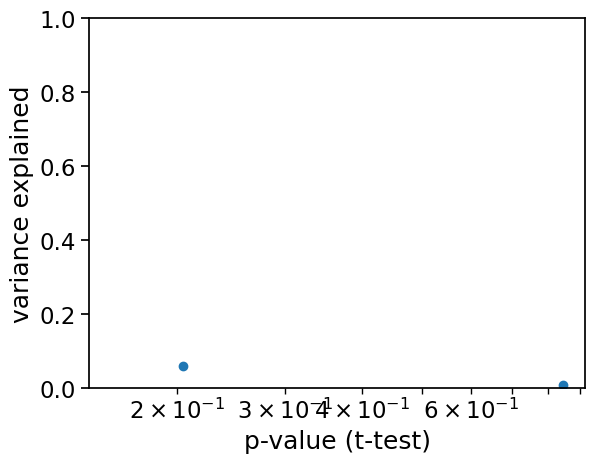

In [54]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(t_test(var_exp.mean(dim='fold', skipna=True),
                  var_exp.std(dim='fold', skipna=True),
                  num_folds), var_exp.mean(dim='fold', skipna=True))
ax.set_xscale('log')
ax.set_xlabel('p-value (t-test)')
ax.set_ylabel('variance explained')
ax.set_ylim([0, 1])

In [74]:
# dropouts
feature_drop_prefix = {'image': ['image'],
                  'change': ['hits', 'misses'],
                  'omission': ['omissions'],
                  'behavior': ['running', 'pupil', 'licks'],
                  'biometrics': ['running', 'pupil'],
                  'running': ['running'],
                  'pupil': ['pupil'],
                  'licks': ['licks'],
                  'hits': ['hits'],
                  'misses': ['misses'],
                  'task': ['hits', 'misses', 'licks']
                  }
interp_events = get_interpolated_events(session, X)
ridge_splits_inds, fit_splits_inds = get_split_inds(X, num_folds=5)
optimal_lam = find_optimal_lam(interp_events, X, ridge_splits_inds)
optimal_lam = optimal_lam.assign_coords(feature_drop='none')
var_exp, predicted_events = fit_cell(interp_events, X, fit_splits_inds, optimal_lam)
var_exp = var_exp.assign_coords(feature_drop='none')
predicted_events = predicted_events.assign_coords(feature_drop='none')

for prefix_key in feature_drop_prefix.keys():
    prefix_list = feature_drop_prefix[prefix_key]
    weight_names = []
    for prefix in prefix_list:
        weight_names += [n for n in X.weights.values if prefix in n]
    Xd = X.drop_sel(weights=weight_names)
    optimal_lam_d = find_optimal_lam(interp_events, Xd, ridge_splits_inds)
    optimal_lam_d = optimal_lam_d.assign_coords(feature_drop=prefix_key)
    optimal_lam = xr.concat([optimal_lam, optimal_lam_d], dim='feature_drop')

    var_exp_d, predicted_events_d = fit_cell(interp_events, Xd, fit_splits_inds, optimal_lam_d)
    var_exp_d = var_exp_d.assign_coords(feature_drop=prefix_key)    
    var_exp = xr.concat([var_exp, var_exp_d], dim='feature_drop')
    predicted_events_d = predicted_events_d.assign_coords(feature_drop=prefix_key)
    predicted_events = xr.concat([predicted_events, predicted_events_d], dim='feature_drop')

    

In [215]:
import sys
sys.getsizeof(interp_events.values)/1024/1024*30*10/1024

# when having 4-500 cells, with max 4x timepoints,
# the memory usage is about 5GB for traces.
# The rest of the memory usage is negligible.
# So, make the predicted traces for each model
# total usage should be less than 10 GB

1.287762075662613

In [223]:
sys.getsizeof(predicted_events.values)/(2**20)*30*4/1024

5.150929391384125

In [75]:
mean_var_exp = var_exp.mean(dim='fold', skipna=True)

In [77]:
mean_var_exp.feature_drop.values

array(['none', 'image', 'change', 'omission', 'behavior', 'biometrics',
       'running', 'pupil', 'licks', 'hits', 'misses', 'task'],
      dtype=object)

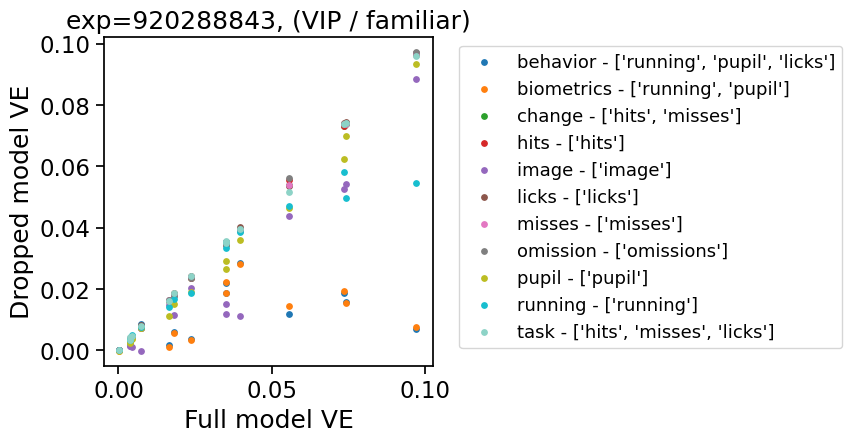

In [117]:
drop_names = np.setdiff1d(mean_var_exp.coords['feature_drop'].values, ['none'])
cmap1 = plt.get_cmap('tab10')
cmap2 = plt.get_cmap('Set3')
cmap_list = [cmap1(i) for i in range(10)] + [cmap2(i) for i in range(12)]
fig, ax = plt.subplots(figsize=(9,9))
for ni, name in enumerate(drop_names):
    ax.scatter(mean_var_exp.sel(feature_drop='none').values,
               mean_var_exp.sel(feature_drop=name).values,
               s = 15,
               label=f'{name} - {feature_drop_prefix[name]}', color=cmap_list[ni])
ax.set_xlabel('Full model VE')
ax.set_ylabel('Dropped model VE')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=13)
ax.axis('square')

row = selected_oeids[selected_oeids.index == oeid]
ax.set_title(f'exp={oeid}, ({row.cre.values[0]} / {row.session_type.values[0]})')
fig.tight_layout()

In [134]:
mean_var_exp

<xarray.DataArray (feature_drop: 12, cell_specimen_id: 15)>
array([[ 5.54354270e-02,  1.79336855e-02,  9.70634444e-02,
         2.36839979e-02,  7.40310102e-02,  3.49785280e-02,
         3.49047551e-02,  1.63693460e-02,  3.95273375e-02,
         4.41597503e-03,  5.62753894e-05,  7.39265232e-03,
         3.71482267e-03,  3.74067659e-03,  7.36461065e-02],
       [ 4.38232362e-02,  1.14642236e-02,  8.85367919e-02,
         2.03635827e-02,  5.41835412e-02,  1.18630065e-02,
         1.49787741e-02,  1.47496730e-02,  1.13098601e-02,
         1.26137518e-03,  4.43175785e-05, -2.61993010e-04,
         1.44517200e-03,  1.52960060e-03,  5.25747710e-02],
       [ 5.39946758e-02,  1.79103133e-02,  9.68477374e-02,
         2.36828136e-02,  7.37913681e-02,  3.54810045e-02,
         3.45612236e-02,  1.61934836e-02,  3.88764316e-02,
         4.51234506e-03,  5.62285508e-05,  7.29074081e-03,
         3.74514551e-03,  3.49472702e-03,  7.32548780e-02],
       [ 5.61127438e-02,  1.78848089e-02,  9.73941979e-02,
         2.36519507e-02,  7.42358820e-02,  3.42881724e-02,
         3.51321706e-02,  1.64600556e-02,  3.94973622e-02,
         4.45150468e-03,  5.87592061e-05,  7.34965135e-03,
         3.75432390e-03,  3.71611334e-03,  7.37200919e-02],
       [ 1.19054009e-02,  6.17031481e-03,  7.12264158e-03,
         3.77076183e-03,  1.58821734e-02,  2.18620280e-02,
         1.88126720e-02,  1.69692353e-03,  2.85495023e-02,
         4.31020080e-03, -1.20083335e-05,  8.68186228e-03,
         3.19098778e-03,  2.33413504e-03,  1.87594506e-02],
       [ 1.46033642e-02,  5.55080468e-03,  7.63270241e-03,
         3.39846318e-03,  1.55906688e-02,  2.22897759e-02,
         1.86270673e-02,  1.21512099e-03,  2.80660535e-02,
         4.12647590e-03, -1.09849978e-04,  7.77102835e-03,
         2.62663879e-03,  2.59790163e-03,  1.95256036e-02],
       [ 4.69308360e-02,  1.66847581e-02,  5.45135193e-02,
         1.87761751e-02,  4.95392740e-02,  3.52108268e-02,
         3.33088289e-02,  1.42381619e-02,  3.84687098e-02,
         5.19617769e-03,  1.86719796e-04,  7.67786497e-03,
         3.78041738e-03,  3.51531963e-03,  5.81268752e-02],
       [ 4.63695512e-02,  1.50982025e-02,  9.32467860e-02,
         1.90134086e-02,  6.97590431e-02,  2.66918647e-02,
         2.91911031e-02,  1.12907738e-02,  3.59356318e-02,
         3.79700823e-03, -2.87255536e-05,  7.28541373e-03,
         2.67136657e-03,  2.45965784e-03,  6.24355555e-02],
       [ 5.37174616e-02,  1.86050147e-02,  9.63659752e-02,
         2.42880409e-02,  7.44838409e-02,  3.52723876e-02,
         3.53608087e-02,  1.63502261e-02,  4.03342740e-02,
         4.70686286e-03,  5.97178593e-05,  8.18052111e-03,
         4.19855113e-03,  3.69843710e-03,  7.42059471e-02],
       [ 5.54745450e-02,  1.79329164e-02,  9.70108453e-02,
         2.35683485e-02,  7.39488113e-02,  3.50962354e-02,
         3.44024849e-02,  1.61964578e-02,  3.92533875e-02,
         4.50916561e-03,  5.62714635e-05,  7.25511196e-03,
         3.75467232e-03,  3.49860161e-03,  7.31702081e-02],
       [ 5.39895089e-02,  1.79112209e-02,  9.68980106e-02,
         2.38028272e-02,  7.38841191e-02,  3.53379015e-02,
         3.50803725e-02,  1.63667595e-02,  3.91484138e-02,
         4.41934113e-03,  5.62324711e-05,  7.43456353e-03,
         3.70539710e-03,  3.72513543e-03,  7.37420929e-02],
       [ 5.17753349e-02,  1.85865462e-02,  9.58320620e-02,
         2.42827412e-02,  7.41519706e-02,  3.55438805e-02,
         3.50728498e-02,  1.60581862e-02,  3.96850823e-02,
         4.63185945e-03,  5.97166947e-05,  8.10858563e-03,
         4.25221448e-03,  3.39138563e-03,  7.38692725e-02]])
Coordinates:
  * cell_specimen_id  (cell_specimen_id) int64 1086571383 ... 1086576588
  * feature_drop      (feature_drop) object 'none' 'image' ... 'misses' 'task'

# XGBoost

In [144]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

def object_xgb(space, X_train, y_train, X_test, y_test, num_round=200):
        xgb_params = {'max_depth' : int(space['max_depth']),
                        'gamma' : space['gamma'],
                        'learning_rate' : space['learning_rate'],
                        'min_child_weight' : space['min_child_weight'],
                        'scale_pos_weight' : space['scale_pos_weight'],
                        'subsample' : space['subsample'],
                        'objective' : 'reg:squarederror',
                        'verbosity' : 0,
                        'seed' : 2925,
                        'device' : 'cuda'} 
        if 'num_round' in space.keys():
            num_round = int(space['num_round'])
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test)
        xgb_model = xgb.train(xgb_params, dtrain, num_round)
        # y_pred_train = xgb_model.predict(dtrain)
        y_pred_test = xgb_model.predict(dtest)
        loss = np.sqrt(np.sum((y_pred_test - y_test)**2))
        # # loss = np.var((y_test - y_pred)) / np.var((y_test - np.mean(y_test)))
        # loss1 = np.var((y_test - y_pred_test)) / np.var((y_test - np.mean(y_test)))
        # ve_train = 1 - np.var((y_train - y_pred_train)) / np.var((y_train - np.mean(y_train)))
        # ve_test = 1 - np.var((y_test - y_pred_test)) / np.var((y_test - np.mean(y_test)))
        # if ve_test <= 0 or ve_train <= 0:
        #     loss2 = 1e10
        # else:
        #     loss2 = ve_train / ve_test
        # loss = loss1 * loss2
        return {'loss': loss, 'status': STATUS_OK,
                'max_depth': space['max_depth'],
                'gamma': space['gamma'],
                'learning_rate': space['learning_rate'],
                'min_child_weight': space['min_child_weight'],
                'scale_pos_weight': space['scale_pos_weight'],
                'subsample': space['subsample'], 
                'num_round': num_round,}

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.loguniform ('gamma', -10, -1),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 100),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'num_round': hp.quniform('num_round', 50, 200, 1),
         }

In [139]:
cell_ind = 3
y = interp_events.isel(cell_specimen_id=cell_ind)

best_params = []
loss_values = []
num_folds = len(ridge_splits_inds)
for fi in range(num_folds):
    train_inds = np.concatenate([ridge_splits_inds[i] for i in range(num_folds) if i != fi])
    test_inds = ridge_splits_inds[fi]
    X_train = X.isel(timestamps=train_inds)
    X_test = X.isel(timestamps=test_inds)
    y_train = y.isel(timestamps=train_inds)
    y_test = y.isel(timestamps=test_inds)

    trials = Trials()

    # initial_loss = np.sqrt(np.sum(y_test ** 2))
    # print(f'Initial loss: {initial_loss}')
    
    best_param_cv = fmin(fn=lambda space: object_xgb(space, X_train, y_train, X_test, y_test),
                         space=space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    best_params.append(best_param_cv)
    loss_values.append(trials.losses())

100%|██████████| 50/50 [00:40<00:00,  1.22trial/s, best loss: 2.230921009466897] 


In [140]:
mean_best_params = {k: np.mean([x[k] for x in best_params]) for k in best_params[0].keys()}
mean_best_params

{'gamma': 0.2042627939830096,
 'learning_rate': 0.0769688247632889,
 'max_depth': 6.4,
 'min_child_weight': 8.2,
 'num_round': 126.2,
 'scale_pos_weight': 51.605193340940005,
 'subsample': 0.7709187360050042}

(0.0, 10.0)

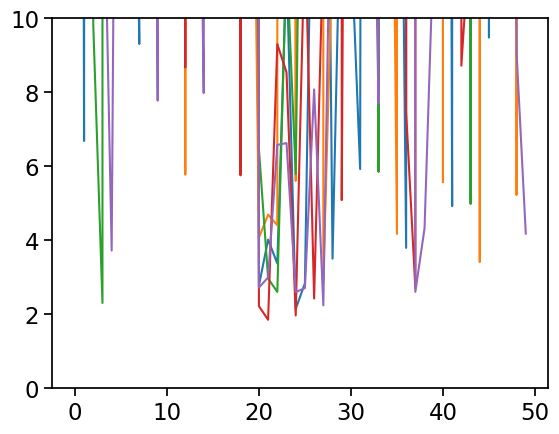

In [142]:
fig, ax = plt.subplots()
for loss in loss_values:
    ax.plot(loss)
ax.set_ylim([0, 10])

Text(0, 0.5, 'VE (train)')

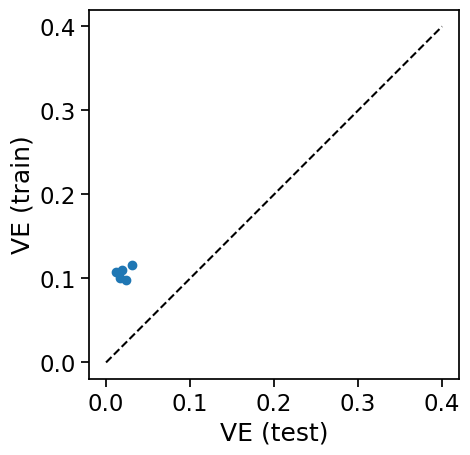

In [143]:
xgb_params_test = {'objective': "reg:squarederror", # for Gaussian noise regression
    'seed': 2925, #for reproducibility
    'verbosity': 0,
    'learning_rate': mean_best_params['learning_rate'],
    'min_child_weight': mean_best_params['min_child_weight'],
    'subsample': mean_best_params['subsample'],
    'max_depth': int(mean_best_params['max_depth']),
    'gamma': mean_best_params['gamma'],
    'device': 'cuda',
    'scale_pos_weight': mean_best_params['scale_pos_weight'],
    }

ve_train = np.zeros(num_folds)
ve_test = np.zeros(num_folds)
loss_train = np.zeros(num_folds)
loss_test = np.zeros(num_folds)
for fi in range(num_folds):
    train_inds = np.concatenate([fit_splits_inds[i] for i in range(num_folds) if i != fi])
    test_inds = fit_splits_inds[fi]
    X_train = X.isel(timestamps=train_inds)
    X_test = X.isel(timestamps=test_inds)
    y_train = y.isel(timestamps=train_inds)
    y_test = y.isel(timestamps=test_inds)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    bst = xgb.train(xgb_params_test, dtrain, int(mean_best_params['num_round']))

    # training set (to check overfitting)
    Ypred = bst.predict(dtrain)
    ve_train[fi] = 1 - np.var((y_train - Ypred)) / np.var(y_train - np.mean(y_train))
    # loss_train[fi] = np.sqrt(np.mean((y_train - Ypred)**2))

    # test set
    Ypred = bst.predict(dtest)
    ve_test[fi] = 1 - np.var((y_test - Ypred)) / np.var((y_test - np.mean(y_test)))
    # loss_test[fi] = np.sqrt(np.mean((y_test - Ypred)**2))

fig, ax = plt.subplots()
ax.scatter(ve_test, ve_train)
ax.plot([0, 0.4], [0, 0.4], 'k--')
ax.axis('square')
ax.set_xlabel('VE (test)')
ax.set_ylabel('VE (train)')
# fig, ax = plt.subplots(1,2,figsize=(15,10))
# ax[0].scatter(ve_test, ve_train)
# ax[0].plot([0, 0.4], [0, 0.4], 'k--')
# ax[0].axis('square')
# ax[0].set_xlabel('VE (test)')
# ax[0].set_ylabel('VE (train)')
# ax[1].scatter(loss_test, loss_train)
# ax[1].plot([0, 0.4], [0, 0.4], 'k--')
# ax[1].axis('square')
# ax[1].set_xlabel('loss (test)')
# ax[1].set_ylabel('loss (train)')

# Preventing overfitting
- Overfitting metric: VE_train / VE_test. Should be close to 1. 1-2 is acceptable.
- Limit hyperparameter search space to prevent overfitting
    - Lower max_depth
    - Lower learning_rate
    - Larger gamma
    - Larger min_child_weight
    - Smaller subsample
    
- Ignore scale_pos_weight

    

In [67]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.loguniform ('gamma', -10, -1),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'num_round': hp.quniform('num_round', 50, 200, 1),
         }

array([0., 0., 0., 0., 0.])

In [70]:
fit_splits_inds

[array([ 20,  53, 177,  89,  49, 101, 211, 143, 114,   9, 124, 195,  27,
        174, 116, 172,  57,  63, 147, 132, 148, 164, 185, 189,  90, 162,
         36,  99, 118, 184,  76,  40,   8, 134, 121, 178,  34, 210, 157,
        111,  28, 115,  48]),
 array([102, 158, 150, 126,  18, 163,  72, 213, 120, 166,  54, 165, 207,
        170,   7,  94,  52, 141,  41,  10, 194, 212,  96,  11, 181,  81,
        197,  43,  29, 137,  56, 144, 100, 201, 208,  73, 146, 153, 183,
         93, 199,  50,  22]),
 array([ 86, 106,  79,  71,  75,  82, 155,  95, 205,  98,  17, 209,   5,
        167, 105,  47, 130,  84,  74,  16,  51,   6,  58, 135, 179, 161,
         30,  78, 151,  61,  33, 107,  31, 129,  92,   2,   1, 175,  13,
         67, 113, 198,  91]),
 array([193,  85,  83,  25,  59, 110,  70, 131,  15, 160, 108, 123,  77,
         38,  87, 145,  65, 188, 140, 204,  55,  60,  45, 173,  39, 203,
        109,  19, 149, 200, 122, 117,  21,  44, 168,  62,  32, 154,  97,
        156, 206, 176, 169]),
 arr

In [267]:
def object_lgb(space, X_train, y_train, X_test, y_test, num_round=200):
        lgb_params = {'max_depth' : int(space['max_depth']),
                        'gamma' : space['gamma'],
                        'learning_rate' : space['learning_rate'],
                        'min_child_weight' : space['min_child_weight'],
                        'scale_pos_weight' : space['scale_pos_weight'],
                        'subsample' : space['subsample'],
                        'objective' : 'reg:squarederror',
                        'verbosity' : 0,
                        'seed' : 2925,
                        'device' : 'cuda'} 
        if 'num_round' in space.keys():
            num_round = int(space['num_round'])
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
        gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        loss = np.sqrt(np.sum((y_pred - y_test)**2))
        return {'loss': loss, 'status': STATUS_OK,
                'max_depth': space['max_depth'],
                'gamma': space['gamma'],
                'learning_rate': space['learning_rate'],
                'min_child_weight': space['min_child_weight'],
                'scale_pos_weight': space['scale_pos_weight'],
                'subsample': space['subsample'], 
                'num_round': num_round,}

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.loguniform ('gamma', -10, -1),
         'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 100),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'num_round': hp.quniform('num_round', 50, 200, 1),
         }